In [1]:
import math
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from math import *
import pandas

# Calculate the carrier drift mobility

This jupyter notebook is a complementary document related to the website https://bodetlea.wixsite.com/the-future-of-solar/general-6 which is related to the study of the solar cell in mapi perovskite compared to the silicon solar cell. Please find a more described and commented version in the link above. $\newline$
The main resolution is following the key steps described in by Poncé et. al. in [1]

## 0) Input of the variables

In [2]:
#unit convertor to Hartree atomic units (a.u.)
KtoHa_kB = 3.16680853419072*10**(-6)
evtoHa = 0.0367492929 
HatoJ = 4.3597482*10**(-18)
BohrtoCm = 5.29177249*10**(-9)
hPlancktoJs = 1.054571817*10**(-34) # where hPlanck is Planck constant over two pi 
AtoBohr = 1.8897161646320724 # where A is in Angstrom
PHztoHa = 0.1519828500716 # where PHz is equal to 10^15 Hz
hPlanck = 1

#effective masses for the electron and hole in a.u.
me_eff = [0.62, 0.62, 0.09] #0.203 # in [m_e]
mh_eff =  [-0.67, -0.67, -0.33]#
mh_eff_iso = [-0.214, -0.214, -0.214]#-0.214 # in [m_e]


T_sample = np.linspace(40,320,50)
T_Ha = np.multiply(T_sample,KtoHa_kB)

#Reciprocal cell vectors (1/Å)
b1 = [0.7342978269,0,0]
b2 = [0,0.4846771787,0]
b3 = [0,0,0.6792294986]

E_f = -0.2 * evtoHa  #Fermi energy close to the conduction band
E_f2 = 0.2 * evtoHa  #Fermi energy close to the valence band

k_ref = np.divide(np.array([b1[0],b2[1],b3[2]]),AtoBohr) #1/Å to 1/Bohr
kx = np.linspace(-k_ref[0]/2,k_ref[0]/2,20)
ky = np.linspace(-k_ref[1]/2,k_ref[1]/2,20)
kz = np.linspace(-k_ref[2]/2,k_ref[2]/2,20)
N = kx.size*ky.size*kz.size



def kxyz(x,y,z):
    """
    the function returns a grid of points with coordinates (x, y, z) as an array of the size (N,3)
    """
    k_xyz = []
    for i in range(x.size):
        for j in range(y.size):
            for k in range(z.size):
                k_xyz.append([x[i],y[j],z[k]])    
    return np.array(k_xyz)

k_coord = kxyz(kx,ky,kz)

## 1) Input of the basic functions

In [3]:
def E_nk(k, m, E_f):
    """
    the function returns the Eigenvalues for a dataset of points k, a particle (electron or hole) of 
        mass m and Fermi energy E_f
    """
    energie = hPlanck**2 * (k[0]**2 / (2 * m[0]) + k[1]**2 / (2 * m[1]) + k[2]**2 / (2 * m[2]))
    return energie
    
def v_nk(k, m):
    """
    the function returns the carrier velocity
    """
    return [k[0]*(hPlanck/m[0]), k[1]*(hPlanck/m[1]), k[2]*(hPlanck/m[2])]  #calculated by hand from Eigenvalue
    
def f_nk(E, E_f, T):
    """
    the function returns 1 - the Fermi-Dirac distribution
    """
    x = 1 - (1 / (np.exp((E-E_f)/T) + 1))
    return x


def Deriv_f_nk(E, E_f, T, tau):
    """
    the function returns the derivative of the function f_nk multiplied by tau
    """
    return np.multiply(np.multiply(-f_nk(E, E_f, T),1-f_nk(E, E_f, T)),tau/T)


## Plot energies with effectives masses non isotropic and isotropic


### plot energies with non isotropic mass (in u.a.)

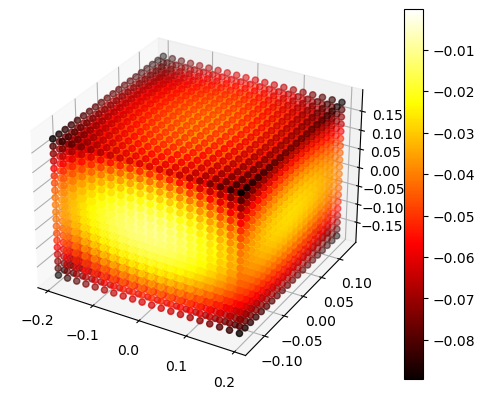

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
Energy = []
for element_0 in range(N):
    x.append(k_coord[element_0][0])
    y.append(k_coord[element_0][1])
    z.append(k_coord[element_0][2])
    k = [x[element_0], y[element_0], z[element_0]]
    Energy.append(E_nk(k, mh_eff, E_f2))
    
c = Energy

img = ax.scatter(x,y,z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

### plot energies with isotropic mass (in u.a.)

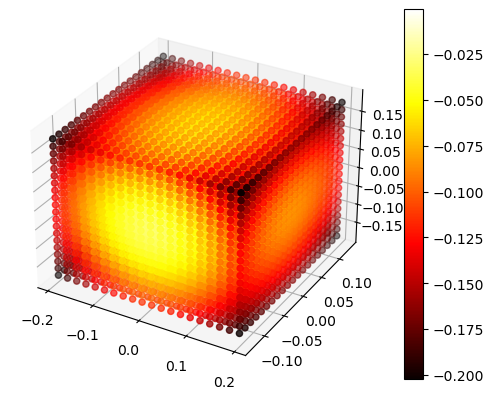

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
Energy = []
for element_0 in range(N):
    x.append(k_coord[element_0][0])
    y.append(k_coord[element_0][1])
    z.append(k_coord[element_0][2])
    k = [x[element_0], y[element_0], z[element_0]]
    Energy.append(E_nk(k, mh_eff_iso, E_f2))
    
c = Energy

img = ax.scatter(x,y,z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

## 2) Conductivity tensor

In [6]:
def sigma(k, m, E_f, T, tau):
    """
    the function returns a simplified value of the conductivity tensor that does not take in account 
        the terms that are simplified during the division with the conductivity tensor 
    """
    
    resultxx = 0
    resultxy = 0
    resultxz = 0
    resultyx = 0
    resultyy = 0
    resultyz = 0
    resultzx = 0
    resultzy = 0
    resultzz = 0
    
    for i in range(N):
        e_nk = E_nk(k[i], m, E_f)
        v = v_nk(k[i], m)
        resultxx += np.multiply(np.multiply(v[0],v[0]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultxy += np.multiply(np.multiply(v[0],v[1]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultxz += np.multiply(np.multiply(v[0],v[2]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultyx += np.multiply(np.multiply(v[1],v[0]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultyy += np.multiply(np.multiply(v[1],v[1]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultyz += np.multiply(np.multiply(v[1],v[2]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultzx += np.multiply(np.multiply(v[2],v[0]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultzy += np.multiply(np.multiply(v[2],v[1]), Deriv_f_nk(e_nk, E_f, T, tau))
        resultzz += np.multiply(np.multiply(v[2],v[2]), Deriv_f_nk(e_nk, E_f, T, tau))
 
    return np.array([[resultxx,resultxy,resultxz],[resultyx,resultyy,resultyz],[resultzx,resultzy,resultzz]])           
        

## 3) Charge carrier density

In [7]:
def n_el(k, m, E_f, T):
    """
    the function returns a simplified value of the charge carrier density of the electrons that does not take in account 
        the terms that are simplified during the division with the carrier density 
    """
    result = 0
    for i in range(k_coord.shape[0]):
        e_nk = E_nk(k[i], m, E_f)
        result += f_nk(e_nk, E_f, T)
    return result

## 4) Carrier drift mobility

In [8]:
def mu_el(k, m, E_f, T_Ha, tau):
    """
    the functions returns the carrier drift mobility for one temperature
    """
    return np.absolute(np.divide(sigma(k, m, E_f, T_Ha, tau),n_el(k, m, E_f, T_Ha)))


## 5) Results

### Holes mobility of the $CH_3NH_3PbI_3$

C:\Users\nico1\AppData\Local\Temp\ipykernel_26492\2604684051.py:5: RuntimeWarning: invalid value encountered in divide
  return np.absolute(np.divide(sigma(k, m, E_f, T_Ha, tau),n_el(k, m, E_f, T_Ha)))


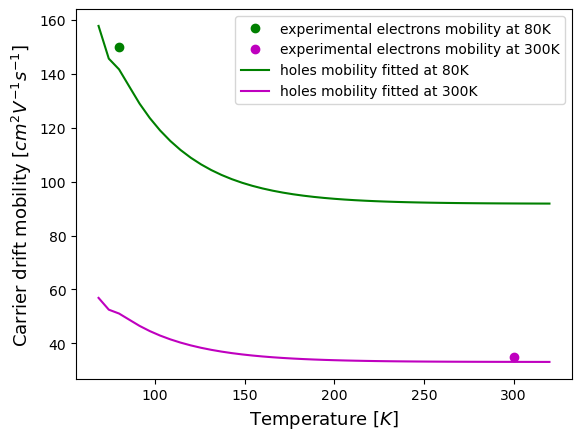

In [9]:
# convert the result from Hartree atomic units to SI units
autoSI = HatoJ * BohrtoCm**2 /(hPlancktoJs)

# initializing the axis
fig1 = plt.figure(1)
ax1 = plt.gca()
ax1.set_ylabel(r"Carrier drift mobility [$cm^2 V^{-1} s^{-1}$] ",fontsize=13)
ax1.set_xlabel(r"Temperature [$K$]",fontsize=13)

# plotting the results experimental datas
real_carrier = [150, 35]
temp = [80, 300]
color = ["go","mo"]
for itera in range(len(real_carrier)):
    plt.plot(temp[itera], real_carrier[itera],color[itera])
    
#the values of the scattering rate
tau_val = [0.86/PHztoHa, 0.31/PHztoHa]


# plotting the curves of the carrier drift mobility for the holes
color3 = ["g","m"]
for iteration in range(len(tau_val)):
    final = np.zeros(len(T_Ha))
    i = 0
    tau = tau_val[iteration]
    for T in T_Ha:
        carrier_mobility = np.multiply(mu_el(k_coord, mh_eff_iso, E_f2, T, tau), autoSI)
        final[i] = np.trace(carrier_mobility)
        i+=1
    plt.plot(T_sample,final,color3[iteration])
    
plt.legend(["experimental electrons mobility at 80K", "experimental electrons mobility at 300K", 
            "holes mobility fitted at 80K", "holes mobility fitted at 300K"])
plt.show()

# References


[1] Samuel Poncé, Wenbin Li, Sven Reichardt, and Feliciano Giustino. First-principles calculations of charge carrier mobility and conductivity in bulk semiconductors and two-dimensional materials.Reports on Progress in Physics, 83(3):036501, feb 2020. $\newline$
    
[2] Milot, R.L., Eperon, G.E., Snaith, H.J., Johnston, M.B. and Herz, L.M. (2015), Temperature-Dependent Charge-Carrier Dynamics     in CH3NH3PbI3 Perovskite Thin Films. Adv. Funct. Mater., 25: 6218-6227. https://doi.org/10.1002/adfm.201502340 $\newline$

[3] Melike Karakus, Søren A. Jensen, Francesco D’Angelo, Dmitry Turchinovich, Mischa Bonn, and Enrique Cánovas. Phonon–electron     scattering limits free charge mobility in methylammonium lead iodide perovskites. The Journal of Physical Chemistry Letters,     6(24):4991–4996, 2015. PMID: 26619006. 